# Web page classification using GPText and MADlib

JULY 2018 , Jupyter Notebook by LEE, HONG-DON (Pivotal Korea, holee@pivotal.io)

## 1. Setting Environment

### 1-1. Import modules

In [1]:
# Common modules
import numpy as np
import pandas as pd
import sklearn

# For DB Connecton
from sqlalchemy import create_engine
import sql_magic

# For reproducibility
np.random.seed(2622)

### 1-2. Setting Visualization Params

In [2]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# To draw plots in jupyter notebook
%matplotlib inline

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8
rcParams['axes.labelsize'] = 14
rcParams['xtick.labelsize'] = 12
rcParams['ytick.labelsize'] = 12

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 1000)

from IPython.display import display
from IPython.display import Image

### 1-3. Setting GPDB Connection

In [3]:
# put your own GPDB information
user = 'gpadmin'
password = 'changeme'
host = '192.168.188.131'
db = 'testdb'

connection_string = "postgresql://{user}:{password}@{host}/{db}".\
    format(user=user, 
           password=password, 
           host=host, 
           db=db)
    
postgres_engine = create_engine(connection_string)

In [4]:
# sql_magic package and ext sql_magic to query GPDB
%load_ext sql_magic
#%reload_ext sql_magic

%config SQL.conn_name = 'postgres_engine'

# '%execsql' for sql execution, '%read_sql' for reading table as a DataFrame format
from IPython.core.magic import (register_line_magic, register_cell_magic, register_line_cell_magic)
@register_cell_magic
def execsql(line, cell):
       _ = postgres_engine.execute(cell)
       return

### sql_magic
#### sql_magic is Jupyter magic for writing SQL to interact with GPDB, Postgres, Spark and Hive. Query results are saved directly to a Pandas dataframe.

For more information >>> https://github.com/pivotal-legacy/sql_magic

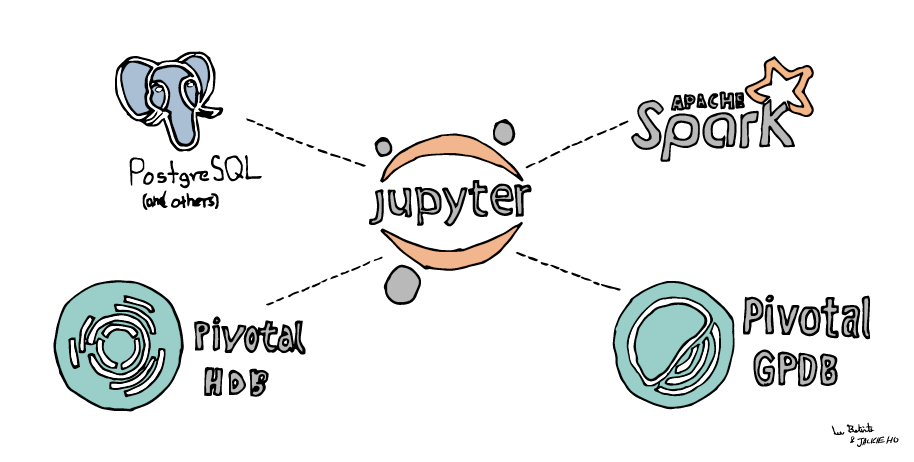

In [5]:
Image(filename='/Users/ihongdon/Documents/GPText/Web_Classification/sql_magic_wide.png')

### 1-4. Setting Directory

In [5]:
import os

# directory where the downloaded data and images are
USER_DOCU_DIR = "/Users/ihongdon/Documents/" # change with your own directory
GPTEXT_PROJECT_DIR = "gptext/web_classification/"
GPTEXT_PROJECT_PATH = os.path.join(USER_DOCU_DIR, GPTEXT_PROJECT_DIR)

## 2. Data Preparation

### 2-1. Goal of Analysis and Description of Data set

- In this demo, I'll show how to use GPText and MADlib to build an SVM model on the 20 news groups dataset. 
- The goal is **to predict if any given post belongs to an IT/Computer Science related discussion board or not.**
- The original dataset can be downloaded from the UCI machine learning repository at : http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups.(http://archive.ics.uci.edu/ml/datasets/Twenty+Newsgroups)

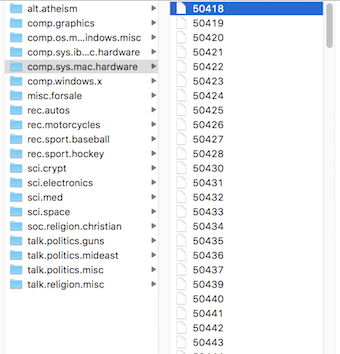

In [7]:
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'twenty_newsgroups_category.png'))

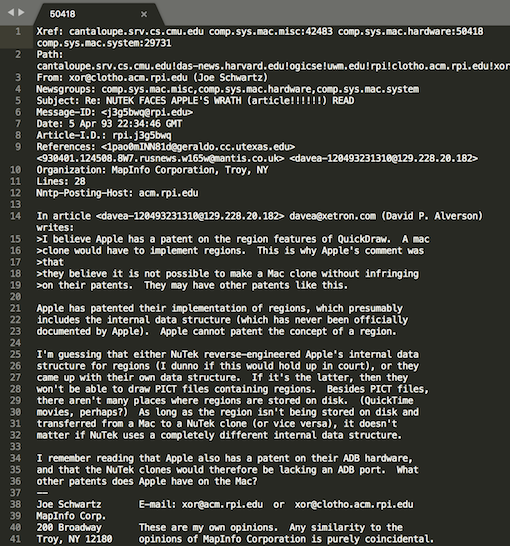

In [8]:
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'news_example.png'))

### 2-2. Create a schema and a table, and upload a dataset

<div class="alert alert-block alert-info">
<b>Transformed dataset:</b> 
<br>With a little bit of python scripting, the downloaded dataset can be transformed into a form that can loaded into a table in GPDB. 
<br> Please use the tranformed & combined into one dataset which is named as <b>'twenty_news_groups.tsv'</b>
</div>

- Create **gpdemo** Schema

In [6]:
%%execsql

drop schema if exists gpdemo cascade;
create schema gpdemo;

- Create **twenty_news_groups** table in gpdemo schema

In [7]:
%%execsql

drop table if exists gpdemo.twenty_news_groups cascade;
create table gpdemo.twenty_news_groups 
(
    doc_id BIGINT
    , contents TEXT
    , label TEXT
) 
distributed by (doc_id);

- Check the schema and table name

In [8]:
%%read_sql

select table_schema, table_name
    from information_schema.tables
    where table_schema in ('gpdemo') 
    and table_type='BASE TABLE'
    order by table_schema, table_name;

Query started at 02:31:08 PM KST; Query executed in 0.00 m

table_schema          table_name
0       gpdemo  twenty_news_groups

### 2-3. Import dataset into DB table

- (1) Import dataset using PGAdmin III's import menu

In [12]:
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'pgadmin3_tools_import.png'))

- (2) Or you can also upload dataset by using 'COPY' sql script directly
- Use shell script as below first to copy 'twenty_news_groups.tsv' file into '/home/gpadmin/gptext'
<br>
<br>
> ihongdon-ui-MacBook-Pro:~ ihongdon>> cd Downloads 
<br>
<br>
ihongdon-ui-MacBook-Pro:Downloads ihongdon>> scp twenty_news_groups.tsv gpadmin@192.168.188.131:/home/gpadmin/gptext
gpadmin@192.168.188.131's password:   (<--put your password here)<br>
twenty_news_groups.tsv                  100%   43MB  95.3MB/s   00:00    
<br>
ihongdon-ui-MacBook-Pro:Downloads ihongdon>>

- and then, Copy *twenty_news_groups.tsv* file into *gpdemo.twenty_news_groups* table

In [18]:
%%execsql
copy gpdemo.twenty_news_groups from '/home/gpadmin/gptext/twenty_news_groups.tsv' delimiter E'\t';

- Display some rows from the table

In [9]:
%%read_sql df_news_groups_5

select * from gpdemo.twenty_news_groups limit 5;

Query started at 02:32:18 PM KST; Query executed in 0.00 m

doc_id  \
0      90   
1      46   
2      78   
3      76   
4     108   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  contents  \
0  Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!usc!sdd.hp.com!caen!batcomputer!munnari.oz.au!yoyo.aarnet.edu.au!yoyo.aarnet.edu.au!usenetFrom: chrisb@tafe.sa.edu.au (Chris BELL)Newsgroups: alt.atheismSubject: Re: A visit from the Jehovah's WitnessesDate: 6 Apr 93 02:46:20 GMTOrganization: South Australian Regional Academic and Research NetworkLines: 26Distribution: worldMessage-ID: <chrisb.734064380@bAARNie>References: <bskendigC4KD1z.CDC@netcom.com> <1p8v1aINN9e9@matt.ksu.ksu.edu> <1993Apr1.142854.794@batman.bmd.trw.com> <1993Apr2.154358.18593@cs.nott.ac.uk> <1993Apr2.150556.807@batman.bmd.trw.com>NNTP-Posting-Host: baarnie.tafe.sa.edu.aujbrown@batman.bmd.trw.com writes:>My syllogism is of the form:>A is B.>C is A.>Therefore C is B.>This is a logically valid construction.>Your syllogism, however, is of the form:>A is B.>C is B.>Therefore C is A.>Therefore yours is a logically invalid construction, >and your com...   
1  Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!emory!sol.ctr.columbia.edu!usc!wupost!uunet!olivea!sgigate!sgiblab!adagio.panasonic.com!nntp-server.caltech.edu!keithFrom: keith@cco.caltech.edu (Keith Allan Schneider)Newsgroups: alt.atheismSubject: Re: <Political Atheists?Message-ID: <1pin25INN1f4@gap.caltech.edu>Date: 3 Apr 93 00:51:17 GMTReferences: <1pcrjmINNr9e@gap.caltech.edu> <1993Apr1.092956.944@news.wesleyan.edu>Organization: California Institute of Technology, PasadenaLines: 62NNTP-Posting-Host: punisher.caltech.edu(reference line trimmed)SSAUYET@eagle.wesleyan.edu (SCOTT D. SAUYET) writes:>First, I'll make the assumption that you agree that a murderer is one>who has commited murder.Well, I'd say that a murderer is one who intentionally committed a murder.For instance, if you put a bullet into a gun that was thought to containblanks, and someone was killed with such a gun, the person who actuallyperformed the action isn't the m...   
2  Newsgroups: alt.atheismPath: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!emory!swrinde!zaphod.mps.ohio-state.edu!uwm.edu!wupost!uunet!munnari.oz.au!bunyip.cc.uq.oz.au!griffin!kraken!ednclarkFrom: ednclark@kraken.itc.gu.edu.au (Jeffrey Clark)Subject: Re: Ancient islamic ritualsMessage-ID: <ednclark.734054731@kraken>Sender: news@griffin.itc.gu.edu.auNntp-Posting-Host: kraken.itc.gu.edu.auOrganization: ITC, Griffith University, Brisbane, AustraliaReferences: <1993Apr3.081052.11292@monu6.cc.monash.edu.au> <1pkqe2INN54n@lynx.unm.edu>Date:  6 Apr 93 00:05:31 GMTLines: 27cfaehl@vesta.unm.edu (Chris Faehl) writes:>Why is it more reasonable than the trend towards obesity and the trend towards>depression? You can't just pick your two favorite trends, notice a correlation >in them, and make a sweeping statement of generality. I mean, you CAN, and >people HA

- 1 example of 1st news

In [21]:
print('* doc_id >>> ', df_news_groups_5['doc_id'][0])
print()
print('* contents >>> ', df_news_groups_5['contents'][0])
print()
print('* label >>>', df_news_groups_5['label'][0])

* doc_id >>>  31

* contents >>>  Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!husc-news.harvard.edu!hsdndev!yale!yale.edu!nigel.msen.com!sdd.hp.com!cs.utexas.edu!uunet!olivea!sgigate!odin!fido!solntze.wpd.sgi.com!liveseyNewsgroups: alt.atheismSubject: Re: Ancient islamic ritualsMessage-ID: <1pq9js$9s2@fido.asd.sgi.com>From: livesey@solntze.wpd.sgi.com (Jon Livesey)Date: 5 Apr 93 21:50:52 GMTReferences: <1993Apr3.081052.11292@monu6.cc.monash.edu.au>Organization: sgiNNTP-Posting-Host: solntze.wpd.sgi.comLines: 20In article <1993Apr3.081052.11292@monu6.cc.monash.edu.au>, darice@yoyo.cc.monash.edu.au (Fred Rice) writes:>>  I propose that these two trends -- greater level of general > depression in society (and other psychological problems) and > greater sexual promiscuity -- are linked, with the latter being > a prime cause of the former.  I cannot provide any evidence beyond > this at this stage, but the whole thesis seems very reasonable to > me and I request that people ponder 

- Label distribution
<br>
Stats: There are **20 labels, 1000 instances for each label** except one which has 997. So distribution is even

In [10]:
%%read_sql

select label, count(doc_id) as doc_cnt
from gpdemo.twenty_news_groups
group by label
order by label;

Query started at 02:34:26 PM KST; Query executed in 0.00 m

label  doc_cnt
0                alt.atheism     1000
1              comp.graphics     1000
2    comp.os.ms-windows.misc     1000
3   comp.sys.ibm.pc.hardware     1000
4      comp.sys.mac.hardware     1000
5             comp.windows.x     1000
6               misc.forsale     1000
7                  rec.autos     1000
8            rec.motorcycles     1000
9         rec.sport.baseball     1000
10          rec.sport.hockey     1000
11                 sci.crypt     1000
12           sci.electronics     1000
13                   sci.med     1000
14                 sci.space     1000
15    soc.religion.christian      997
16        talk.politics.guns     1000
17     talk.politics.mideast     1000
18        talk.politics.misc     1000
19        talk.religion.misc     1000

## 3. Text Analysis using GPText

In [6]:
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'data_loading_indexing_workflow.png'))

### 3-1. Create Index

- 3-1-0. preprocess: drop any existing index

In [11]:
%%read_sql

select * from gptext.drop_index('testdb.gpdemo.twenty_news_groups');

Query started at 02:36:07 PM KST; Query executed in 0.05 m

drop_index
0        True

- 3-1-1. Create Empty Index

In [12]:
%%read_sql

select * from gptext.create_index('gpdemo', 'twenty_news_groups', 'doc_id', 'contents');

Query started at 02:36:28 PM KST; Query executed in 0.37 m

create_index
0          True

- 3-1-2. Enable terms table

In [13]:
%%read_sql
select gptext.enable_terms('testdb.gpdemo.twenty_news_groups', 'contents');

Query started at 02:36:50 PM KST; Query executed in 0.05 m

enable_terms
0          True

- 3-1-3. Populate Index

In [14]:
%%read_sql

select * from gptext.index(TABLE(select * from gpdemo.twenty_news_groups), 'testdb.gpdemo.twenty_news_groups');

Query started at 02:36:53 PM KST; Query executed in 0.24 m

dbid  num_docs
0     2      5000
1     3      4998
2     4      4999
3     5      5000

- 3-1-4. Commit Index

In [15]:
%%read_sql

select * from gptext.commit_index('testdb.gpdemo.twenty_news_groups');

Query started at 02:37:08 PM KST; Query executed in 0.04 m

commit_index
0          True

- 3-1-5. Show sample search

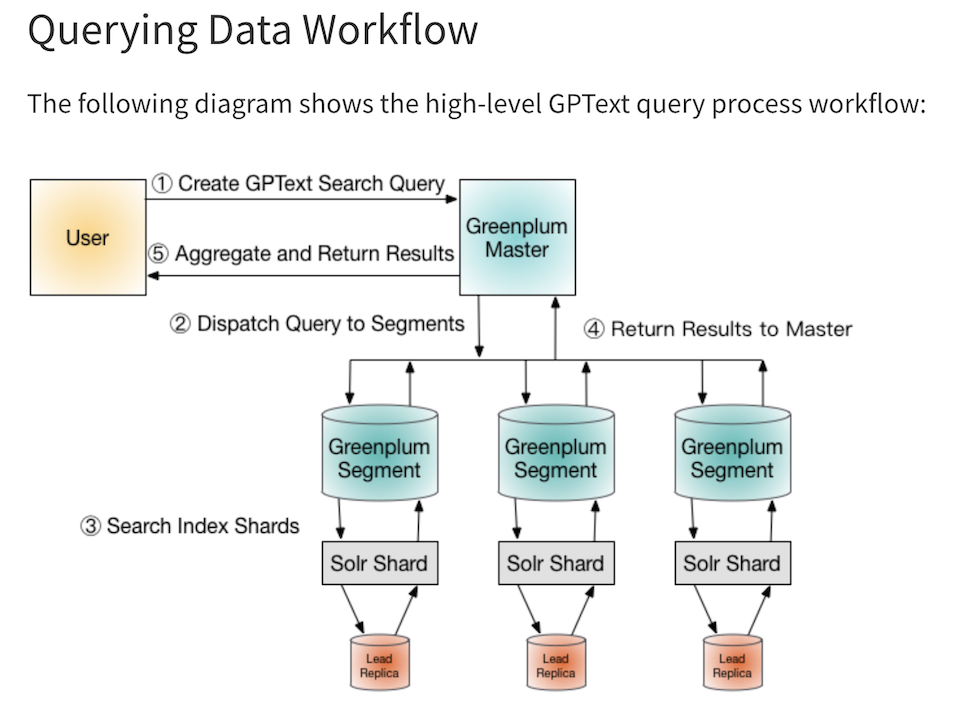

In [8]:
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'querying_data_flow.png'))

In [16]:
%%read_sql search_example

select t1.doc_id
    , t1.contents
    , t2.score -- the TF-IDF score
from gpdemo.twenty_news_groups t1
, (
    select *
    from gptext.search(
        TABLE(select * from gpdemo.twenty_news_groups)
        , 'testdb.gpdemo.twenty_news_groups' -- source table
        , 'clinton'  -- index name
        , null -- filter queries, if none, set this parameter to null
        )
) t2
where t1.doc_id = t2.id
order by score desc
limit 10;

Query started at 02:38:04 PM KST; Query executed in 0.01 m

doc_id  \
0   16874   
1   11123   
2   11405   
3   17235   
4   17231   
5   16752   
6   18183   
7   18928   
8   18292   
9   11558   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  contents  \
0  Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!transfer.stratus.com!sw.stratus.com!cdtFrom: cdt@sw.stratus.com (C. D. Tavares)Newsgroups: talk.politics.gunsSubject: Re: CLINTON JOINS LIST OF GENOCIDAL SOCIALIST LEADERSDate: 22 Apr 1993 17:54:59 GMTOrganization: Stratus Computer, Inc.Lines: 52Distribution: worldMessage-ID: <1r6m5j$64f@transfer.stratus.com>References: <cfonVda00UhW09p5E2@andrew.cmu.edu> <1r00ug$d60@btr.btr.com> <1r569aINN7ss@charnel.ecst.csuchico.edu>NNTP-Posting-Host: rocket.sw.stratus.comIn article <1r569aINN7ss@charnel.ecst.csuchico.edu>, nomad@ecst.csuchico.edu (Michael Larish) writes:> How is Clinton responsible?  It was a law enforcement action.> Granted, it was a nationally covered incident but Clinton had no more to> do with the outcome than Fred Flintstone.Do I think Clinton conceived of it?  No.Do I think Clinton ordered it?  No.Do I think...   
1  Xref: cantaloupe.srv.cs.cmu.edu comp.org.eff.talk:16882 sci.crypt:15265Path: cantaloupe.srv.cs.cmu.edu!das-news.harvard.edu!ogicse!emory!swrinde!network.ucsd.edu!qualcom.qualcomm.com!qualcom!rdippoldFrom: rdippold@qualcomm.com (Ron "Asbestos" Dippold)Newsgroups: comp.org.eff.talk,sci.cryptSubject: Re: Clinton Boost in Spy SpendingMessage-ID: <rdippold.735040094@qualcom>Date: 17 Apr 93 09:48:14 GMTArticle-I.D.: qualcom.rdippold.735040094References: <1993Apr16.192050.11757@daffy.cs.wisc.edu> <1993Apr16.203844.17055@lambda.msfc.nasa.gov> <alasnik.735003783@merle> <1993Apr17.013754.25235@csus.edu>Sender: news@qualcomm.comOrganization: Qualcomm, Inc., San Diego, CALines: 23Originator: rdippold@qualcom.qualcomm.comNntp-Posting-Host: qualcom.qualcomm.comRight on the heels of the Clinton "registered encryption key" debacle comes:sphughes@sfsuvax1.sfsu.edu (Shaun P. Hughes) writes:>[From yesterdays S.F. Chronicle]>"President Clinton has asked Congress for authority to spend more money>on sp...   
2  Xref: cantaloupe.srv.cs.cmu.edu sci.crypt:15549 alt.security:10044 comp.org.eff.talk:17018 comp.security.misc:3487 comp.org.acm:1668 comp.org.ieee:1596Newsgroups: sci.crypt,alt.security,comp.org.eff.talk,comp.security.misc,comp.org.acm,comp.org.ieeePath: cantaloupe.srv.cs.cmu.edu!magnesium.club.cc.cmu.edu!news.sei.cmu.edu!cis.ohio-state.edu!pacific.mps.ohio-state.edu!zaphod.mps.ohio-state.edu!cs.utexas.edu!uunet!boulder!ucsu!spot.Colorado.EDU!andersomFrom: andersom@spot.Colorado.EDU (Marc Anderson)Subject: Re: Once tapped, your code is no good any more.Message-ID: <1993Apr21.001707.9999@ucsu.Colorado.EDU>Sender: news@ucsu.Colorado.EDU (USENET News System)Nntp-Posting-Host: spot.colorado.eduOrganization: University of Colorado, BoulderReferences: <2073@rwing.UUCP> <1993Apr19.193528.5655@cs.ucla.edu> <rdippold.735253985@qualcom>

In [29]:
# Show 1st exmaple in details
print(search_example['contents'][0])

Path: cantaloupe.srv.cs.cmu.edu!crabapple.srv.cs.cmu.edu!bb3.andrew.cmu.edu!news.sei.cmu.edu!fs7.ece.cmu.edu!europa.eng.gtefsd.com!howland.reston.ans.net!noc.near.net!transfer.stratus.com!sw.stratus.com!cdtFrom: cdt@sw.stratus.com (C. D. Tavares)Newsgroups: talk.politics.gunsSubject: Re: CLINTON JOINS LIST OF GENOCIDAL SOCIALIST LEADERSDate: 22 Apr 1993 17:54:59 GMTOrganization: Stratus Computer, Inc.Lines: 52Distribution: worldMessage-ID: <1r6m5j$64f@transfer.stratus.com>References: <cfonVda00UhW09p5E2@andrew.cmu.edu> <1r00ug$d60@btr.btr.com> <1r569aINN7ss@charnel.ecst.csuchico.edu>NNTP-Posting-Host: rocket.sw.stratus.comIn article <1r569aINN7ss@charnel.ecst.csuchico.edu>, nomad@ecst.csuchico.edu (Michael Larish) writes:> How is Clinton responsible?  It was a law enforcement action.> Granted, it was a nationally covered incident but Clinton had no more to> do with the outcome than Fred Flintstone.Do I think Clinton conceived of it?  No.Do I think Clinton ordered it?  No.Do I think Cli

### 3-2. Create Term Table

In [17]:
%%execsql

drop table if exists gpdemo.twenty_news_groups_terms cascade;
create table gpdemo.twenty_news_groups_terms as
(
	select *
	from gptext.terms(
	TABLE(select * from gpdemo.twenty_news_groups)
	, 'testdb.gpdemo.twenty_news_groups'
	, 'contents' -- column for term
	, '*:*' 
	, null
	)
) distributed by (id);

- Check the term table

In [18]:
%%read_sql
select * from gpdemo.twenty_news_groups_terms limit 20;

Query started at 02:40:22 PM KST; Query executed in 0.00 m

id                    term         positions
0   63                       $  [29, 48, 60, 66]
1   63                      $4              [54]
2   63                      00              [41]
3   63                      10              [43]
4   63  1993mar30.051246.29911              [57]
5   63            1p3bn9inn98r              [45]
6   63                  1p5p1j              [47]
7   63            1p6rgcinnhfb              [51]
8   63                  1p88fi              [53]
9   63                  1p8nd7              [59]
10  63            1pa0stinnpqa              [63]
11  63                  1pan4f              [65]
12  63            1pieg7inns09              [76]
13  63                  1pqin2              [28]
14  63                    20in              [74]
15  63                      26              [42]
16  63                       6              [38]
17  63                      93              [40]
18  63                     abl             [172]
19  63                   about   [110, 180, 193]

- Check the number of id, term and row

In [19]:
%%read_sql

select count(distinct id) as id_cnt, count(distinct term) as term_cnt, count(*) as row_cnt 
from gpdemo.twenty_news_groups_terms;

Query started at 02:41:25 PM KST; Query executed in 0.04 m

id_cnt  term_cnt  row_cnt
0   19997    358185  3305436

- Check the distribution of term_freq and decide the threshold for analysis coverage

In [20]:
%%read_sql df_term_freq

with a as (
    select a.term_freq, count(distinct a.term) as term_freq_aggre_num
    from (
        select term, count(id) as term_freq from gpdemo.twenty_news_groups_terms group by term
    ) a
    group by term_freq
    order by term_freq
), 
b as (
    select count(*) as cnt_all
    from gpdemo.twenty_news_groups_terms
)
select a.term_freq, 
    a.term_freq_aggre_num, 
    round(100 * a.term_freq_aggre_num::numeric / b.cnt_all::numeric, 3) as term_freq_aggre_num_pct
from a, b
order by a.term_freq

Query started at 02:42:14 PM KST; Query executed in 0.03 m

term_freq  term_freq_aggre_num  term_freq_aggre_num_pct
0             1               247790                    7.496
1             2                45040                    1.363
2             3                16924                    0.512
3             4                 9315                    0.282
4             5                 6080                    0.184
5             6                 4258                    0.129
6             7                 3057                    0.092
7             8                 2351                    0.071
8             9                 2029                    0.061
9            10                 1579                    0.048
10           11                 1384                    0.042
11           12                 1163                    0.035
12           13                  964                    0.029
13           14                  921                    0.028
14           15                  837                    0.025
15           16                  669                    0.020
16           17                  651                    0.020
17           18                  586                    0.018
18           19                  480                    0.015
19           20                  495                    0.015
20           21                  419                    0.013
21           22                  399                    0.012
22           23                  363                    0.011
23           24                  310                    0.009
24           25                  324                    0.010
25           26                  296                    0.009
26           27                  247                    0.007
27           28                  255                    0.008
28           29                  225                    0.007
29           30                  211                    0.006
...         ...                  ...                      ...
1190       7215                    1                    0.000
1191       7364                    1                    0.000
1192       7420                    1                    0.000
1193       7425                    1                    0.000
1194       7518                    1                    0.000
1195       7558                    1                    0.000
1196       7564                    1                    0.000
1197       7935                    1                    0.000
1198       7942                    1                    0.000
1199       7993                    1                    0.000
1200       8072                    1                    0.000
1201       8238                    1                    0.000
1202       8493                    1                    0.000
1203       8698                    1                    0.000
1204       8761                    1                    0.000
1205       9204                    1                    0.000
1206      10172                    1                    0.000
1207      10306                    1                    0.000
1208      10388                    1                    0.000
1209      10890                    1                    0.000
1210      10944                    1                    0.000
1211      11133                    1                    0.000
1212      11876                    1                    0.000
1213      13163                    1                    0.000
1214      13468                    1                    0.000
1215      13637                    1                    0.000
1216      15171                    1                    0.000
1217      15569                    1                    0.000
1218      18408                    1                    0.000
1219      19997                    2                    0.000

[1220 rows x 3 columns]

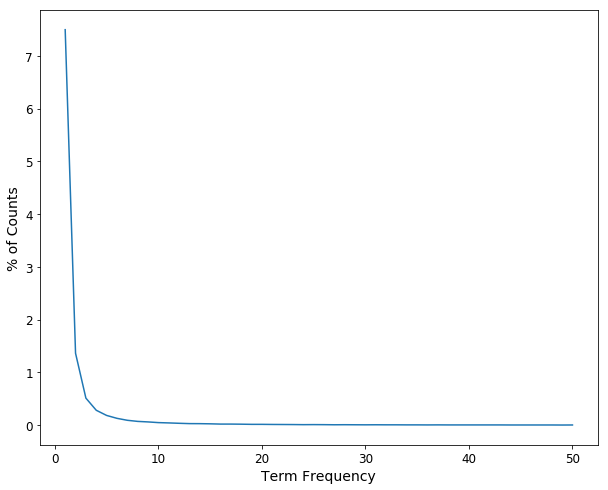

In [34]:
x = df_term_freq['term_freq'][:50]
y = df_term_freq['term_freq_aggre_num_pct'][:50]
plt.plot(x, y)
plt.xlabel('Term Frequency')
plt.ylabel('% of Counts')
plt.show()

### 3-3. Create Term Dictionary

In [21]:
%%execsql

drop table if exists gpdemo.twenty_news_groups_terms_dict cascade;
create table gpdemo.twenty_news_groups_terms_dict as
(
    select row_number() over(order by term asc) as idx
        , term
        , term_freq
    from (
        select term
            , count(*) as term_freq
        from gpdemo.twenty_news_groups_terms
        where term is not null
        group by term
    ) q
    where term_freq > 50 -- disregard terms which occur less than 50 times at least
) distributed by (idx);

- Check the number of term dictionary

In [22]:
%%read_sql

select count(*) from gpdemo.twenty_news_groups_terms_dict;

Query started at 02:43:25 PM KST; Query executed in 0.00 m

count
0   5807

- Check the term dictionary

In [24]:
%%read_sql

select * from gpdemo.twenty_news_groups_terms_dict limit 50;

Query started at 02:43:53 PM KST; Query executed in 0.00 m

idx      term  term_freq
0     4        $1        307
1     8       $12         73
2    12       $20        158
3    16        $3        246
4    20        $4        274
5    24        $5        254
6    28       $60         62
7    32         0        733
8    36        01       1466
9    40        04       1430
10   44        06       1382
11   48        08       1225
12   52       1.1        940
13   56       1.5         90
14   60   100,000         81
15   64  1024x768         71
16   68      10in         71
17   72      11in         76
18   76      1200         96
19   80  12messag         71
20   84  13messag         54
21   88      14in        153
22   92      1500         56
23   96        16       4401
24  100        17       3338
25  104       180         65
26  108      1914         58
27  112      1948         60
28  116      1970         86
29  120      1976         51
30  124      1980        131
31  128      1984         98
32  132      1988        224
33  136      1992        448
34  140      19in        178
35  144       1st        206
36  148       2.2        120
37  152      2000        539
38  156       207         67
39  160        21       4057
40  164       214         79
41  168  21messag         51
42  172       225         58
43  176       230         66
44  180      2400         83
45  184     24bit         54
46  188       255         63
47  192        26       1896
48  196        27       1523
49  200        28       1316

## What is TF-IDF?

- short for **Term Frequency–Inverse Document Frequency**
- a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus
- It is often used as a weighting factor in searches of information retrieval, text mining, and user modeling
- The tf-idf value increases proportionally to the number of times a word appears in the document and is offset by the frequency of the word in the corpus, which helps to adjust for the fact that some words appear more frequently in general.

*source : https://en.wikipedia.org/wiki/Tf-idf*

<div class="alert alert-block alert-info">
<b>> TF(t)</b> = (Number of times term t appears in a document) / (Total number of terms in the document)<br>
<b>> IDF(t)</b> = log(Total number of documents / Number of documents with term t in it)<br>
<b>> TF-IDF</b> = TF * IDF
</div>

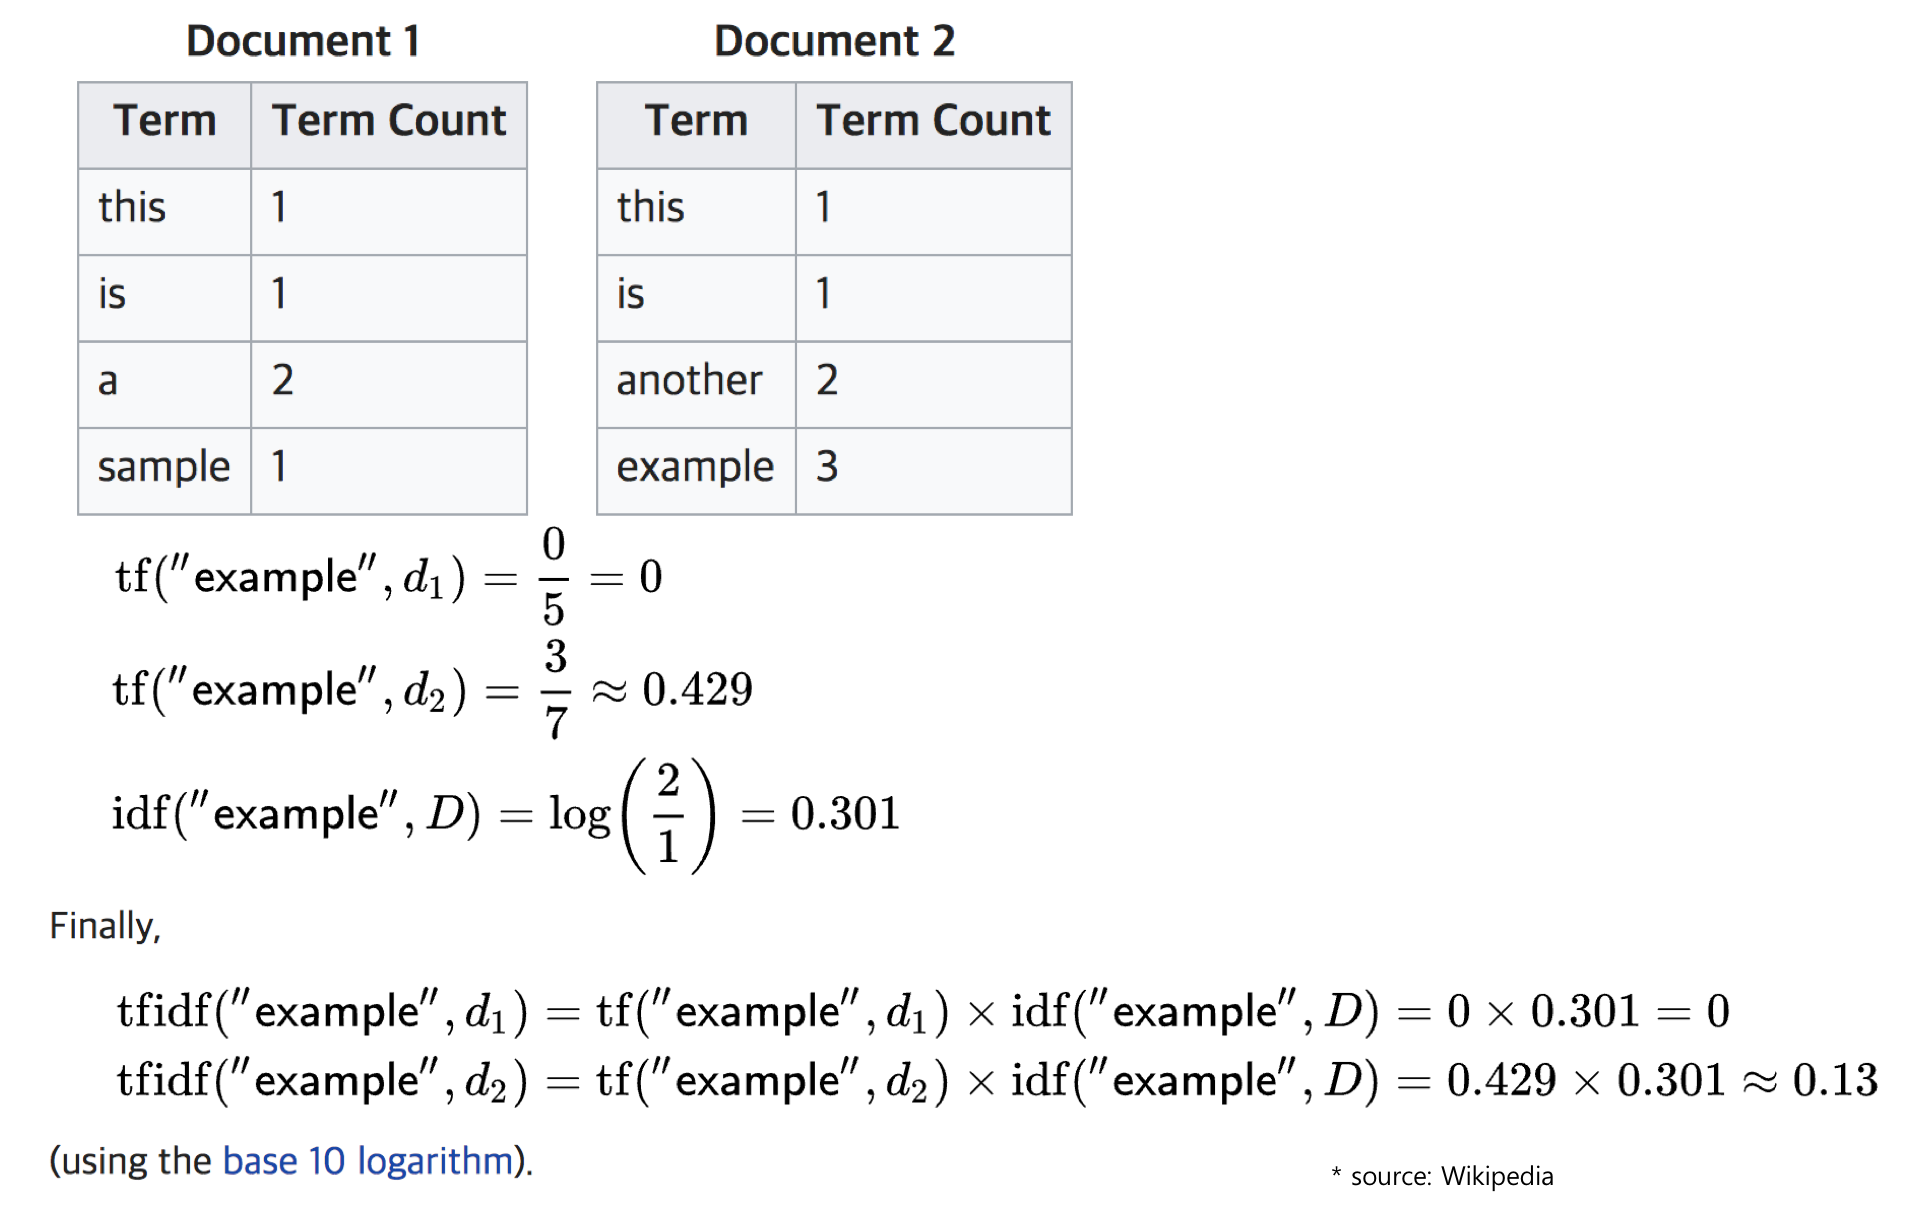

In [38]:
# Example of TF-IDF calculation
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'tf_idf_example_wiki.png'))

### 3-4. Create sparse vectors representation using TF-IDF scores for the corpus

- Corpus Table

In [25]:
%%execsql

drop table if exists gpdemo.twenty_news_groups_corpus cascade;
create table gpdemo.twenty_news_groups_corpus 
as 
(
    select terms.id as doc_id, 
           madlib.svec_cast_positions_float8arr(
        -- Array of terms represented as unique integers
        array_agg(dict.idx),
        -- number of occurrences of the term in the corresponding document (current row)
        array_agg(array_upper(terms.positions, 1)), 
        -- Size of the terms table (number of distinct terms in the corpus)
        -- This is the size of the dense vector, and will used to build the sparse vector
        gptext.count_t('gpdemo.twenty_news_groups_terms_dict'), -- number of terms in dictionary
        0.0
           ) as sfv
    from
         gpdemo.twenty_news_groups_terms terms,
         gpdemo.twenty_news_groups_terms_dict dict
    where
         terms.term = dict.term
    group by terms.id
) distributed by (doc_id);

- Check the sparse vectors representation

In [26]:
%%read_sql df_sfv
select * from gpdemo.twenty_news_groups_corpus limit 10;

Query started at 02:50:07 PM KST; Query executed in 0.00 m

doc_id  \
0  10003   
1  10007   
2  10010   
3  10014   
4  10001   
5  10005   
6  10002   
7  10006   
8  10011   
9  10018   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       sfv  
0  {48,1,191,1,31,1,11,1,74,1,48,1,93,1,14,1,69,1,3,1,44,1,110,1,74,2,7,1,22,1,3,1,12,1,174,2,4,1,5,1,9,1,3,1,14,1,100,1,42,1,66,1,152,1,106,1,2,1,23,1,27,1,17,1,238,1,221,1,33,1,237,1,13,1,16,1,1,1,3,1,6,1,28,1,66,1,26,1,42,1,5,1,3,1,15,1,12,1,13,1,20,1,19,1,4,1,9,1,242,1,38,1,12,1,8,1,93,1,6,1,40,1,61,1,14,1,64,1,22,1,125,1,9,1,28,1,110,1,22,1,10,1,16,1,65,1,21,1,18,1,3,1,3,1,5,1,15,1,13,1,4,1,18,1,67,1,3,1,154,1,23,1,12,1,125,1,48,1,29,1,92,1,46,2,198,1,77,1,124,1,21,1,68,1,237,1,51,2,3,1,2,1,59,1,16,1,113,1,42,1,34,2,119,1,18,1,42,1,40,1,28,1,4,1,38,1,10,1,6,1,9,1,15}:{0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,3,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,3,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,3,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,3,0,1,0,1,0,1,0,1,0,1,0,1,0,1...  
1                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 {1,31,1,152,1,102,1,4,1,65,1,71,1,204,1,147,1,55,1,63,1,13,1,139,1,13,1,152,1,24,1,181,1,99,1,25,1,26,1,34,1,540,1,121,1,80,1,13,1,248,1,45,1,9,1,47,1,159,1,1,6,1,202,1,7,1,211,1,134,1,112,1,18,1,3,1,115,1,154,1,158,1,211,1,29,1,65,1,149,1,118,1,211,1,14,1,102,1,61,1,145,1,513,1,61,1,92}:{3,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,3,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0}  
2  {99,1,36,1,31,1,22,1,7,1,26,1,45,1,10,1,31,1,70,1,38,1,1,1,39,1,81,1,3,1,27,1,54,1,35,1,91,1,5,1,57,1,101,1,50,1,90,1,65,1,1,1,111,1,51,1,87,1,65,1,9,1,75,1,40,1,182,1,79,1,11,1,16,1,109,1,1,1,21,1,42,1,1,22,1,16,1,84,1,53,1,53,1,6,1,8,1,78,1,24,1,48,1,62,1,10,1,68,1,37,2,31,1,11,1,32,1,33,1,20,1,147,1,112,1,95,1,4,1,8,1,34,1,92,2,135,1,92,1,49,1,42,1,10,1,6,1,4,1,23,1,6,1,45,1,27,1,6,1,3,1,41,1,33,1,57,1,19,1,11,1,72,1,178,1,84,1,28,1,156,1,85,1,18,1,29,1,37,1,10,1,1,1,29,1,21,1,73,1,29,1,44,1,72,1,16,1,66,1,126,1,13,1,38,1,17,1,19,1,6,1,26,1,22,1,87,1,75,1,162,1,1,1,57,1,10,1,7,1,33,1,52,1,28,1,44}:{0,1,0,1,0,1,0,1,0,3,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,4,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,7,0,3,0,2,0,1,0,1,0,1,0,1,0,1,5,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,

In [42]:
print(df_sfv['sfv'][0])

{48,1,191,1,31,1,11,1,74,1,48,1,93,1,14,1,69,1,3,1,44,1,110,1,74,2,7,1,22,1,3,1,12,1,174,2,4,1,5,1,9,1,3,1,14,1,100,1,42,1,66,1,152,1,106,1,2,1,23,1,27,1,17,1,238,1,221,1,33,1,237,1,13,1,16,1,1,1,3,1,6,1,28,1,66,1,26,1,42,1,5,1,3,1,15,1,12,1,13,1,20,1,19,1,4,1,9,1,242,1,38,1,12,1,8,1,93,1,6,1,40,1,61,1,14,1,64,1,22,1,125,1,9,1,28,1,110,1,22,1,10,1,16,1,65,1,21,1,18,1,3,1,3,1,5,1,15,1,13,1,4,1,18,1,67,1,3,1,154,1,23,1,12,1,125,1,48,1,29,1,92,1,46,2,198,1,77,1,124,1,21,1,68,1,237,1,51,2,3,1,2,1,59,1,16,1,113,1,42,1,34,2,119,1,18,1,42,1,40,1,28,1,4,1,38,1,10,1,6,1,9,1,15}:{0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,1,0,1,0,1,0,3,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,3,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,3,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,1,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,2,0,2,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,3,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1

- Return log (natural) if input is >0 else return 0

In [29]:
%%execsql

drop function if exists gpdemo.log_nonzero(double precision) cascade;
create or replace function gpdemo.log_nonzero(x double precision)
returns double precision
as
$$
    import math
    base=math.e
    retval = math.log(x, base) if(x>0) else 0
    return retval
$$language plpythonu;

- TF-IDF feature vector

In [30]:
%%execsql

-- We'll use the Stnadard Information Retrieval Measure for tf_idf
-- tf_idf score of term t_i in document d = log(term frequence of t_i in document d+1)*log(|D|/# Documents in which t_i occurred in)
-- w_t, d = (1+log tf_t, d)*log(|D|/df_t)
drop table if exists gpdemo.twenty_news_groups_fvect_tfidf;
create table gpdemo.twenty_news_groups_fvect_tfidf 
    as
    (
    select doc_id
    -- tf-idf scores for each term in the document
    , madlib.svec_mult(
        -- Compute (1+log tf_t, d)
        madlib.svec_plus(1::madlib.svec, madlib.svec_lapply('gpdemo.log_nonzero', sfv))
        , foo.logidf
        ) as tf_idf
    from gpdemo.twenty_news_groups_corpus, 
        -- The idf vector is the same for every document (as idf of a term is independent of the document it occurs in)
        ( 
        -- Compute log (|D|/count(t_i)) where |D| is the number of documents
        -- and t_i is the number of documents in which term t_i occurred in
        select madlib.svec_lapply(
            'gpdemo.log_nonzero'
            , madlib.svec_div(
                -- Total number of documents
                count(sfv)::madlib.svec
                -- count_non_zeros returns the number of documents in which a term t_i occurred in.
                -- It computes this by expanding each document vector into
                -- a list of columns and counts the number of non-zero values in each column
                , madlib.svec_count_nonzero(sfv)
                     )
                    ) as logidf
        from gpdemo.twenty_news_groups_corpus
        ) foo
    order by doc_id
) distributed by (doc_id);

- Display the corpus

In [31]:
%%read_sql df_fvect_tfidf
select * from gpdemo.twenty_news_groups_fvect_tfidf limit 10;

Query started at 02:53:58 PM KST

ProgrammingError: (psycopg2.ProgrammingError) relation "gpdemo.twenty_news_groups_fvect_tfidf" does not exist
LINE 1: select * from gpdemo.twenty_news_groups_fvect_tfidf limit 10...
                      ^
 [SQL: 'select * from gpdemo.twenty_news_groups_fvect_tfidf limit 10;']

In [50]:
print(df_fvect_tfidf['tf_idf'][0])

{1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,2,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1

### 3-5. Create Train & Test sets, to build a predictive model using SVM

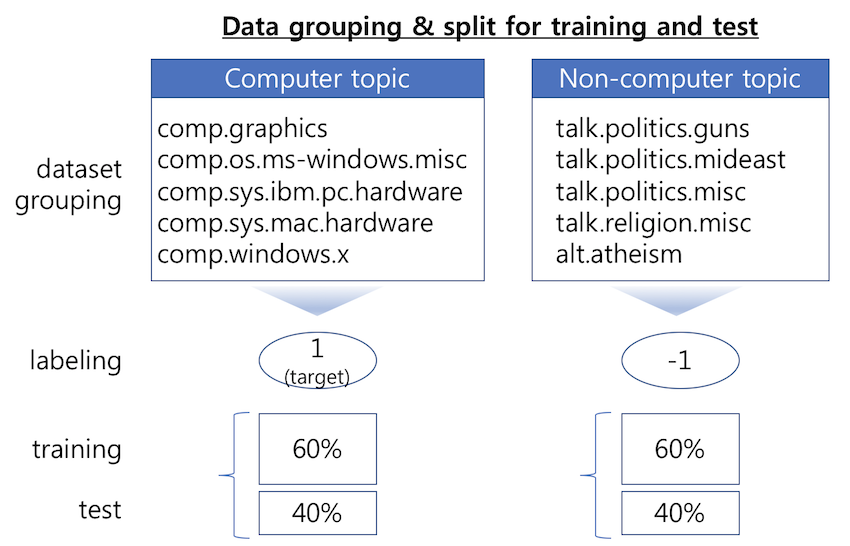

In [51]:
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'dataset_training_test.png'))

- grouped into two categories : computer vs. non-computer

In [52]:
%%execsql

drop table if exists gpdemo.twenty_news_groups_fvect_tfidf_all cascade;
create table gpdemo.twenty_news_groups_fvect_tfidf_all as (
    select t1.doc_id as id
        , madlib.svec_return_array(t1.tf_idf) as ind
        , random() as rand_num -- fro training, test set split
        -- We'll detect if a news group discussion is about computers or not
        , case when t2.label in (
            'comp.graphics', 
            'comp.os.ms-windows.misc', 
            'comp.sys.ibm.pc.hardware', 
            'comp.sys.mac.hardware', 
            'comp.windows.x') then 1 else -1
        end as label
    from gpdemo.twenty_news_groups_fvect_tfidf t1, gpdemo.twenty_news_groups t2
    where t1.doc_id = t2.doc_id 
        and label in (
        -- Picking 10 labels - 5 about computers, 5 about a mix of politics & religion - ensuring distribution is still even
        'talk.politics.guns',
        'talk.politics.mideast',
        'talk.politics.misc',
        'talk.religion.misc',
        'alt.atheism',
        'comp.graphics',
        'comp.os.ms-windows.misc',
        'comp.sys.ibm.pc.hardware',
        'comp.sys.mac.hardware',
        'comp.windows.x'
        )
) distributed by (id);

In [53]:
%%read_sql

select * from gpdemo.twenty_news_groups_fvect_tfidf_all limit 3;

Query started at 05:39:57 PM KST; Query executed in 0.00 m

id  \
0  1001   
1  1002   
2  1003   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       ind  \
0  [1.84786239953, 5.80899297906, 5.47252074244, 4.1764897937, 4.82816372605, 4.71595173544, 5.77620315624, 5.61287810014, 5.16713909289, 5.36004275901, 4.67759086757, 4.84074250826, 5.2981673553, 5.21198965906, 5.49661829402, 4.39800600535, 5.02814021808, 5.19380733997, 5.68382983611, 4.2902094349, 5.46068628479, 5.79246367711, 5.86028627345, 4.36600327427, 4.89939123534, 5.36004275901, 4.25436330312, 5.77620315624, 5.05130727737, 4.66159052623, 4.90612526752, 3.3061918394, 3.77355105862071, 4.65106411324, 5.61287810014, 2.61304465884, 5.97151190856, 2.57884756194, 2.69399728468, 2.63790781803, 3.41717675234, 2.74094004393, 4.46525823236, 2.67205053696, 5.65484229924, 2.70740031481, 4.84074250826, 2.79264141831, 2.681501716, 2.44667464263817, 5.50888838661, 3.05745766602, 5.26860855306, 5.72895027139, 4.72718780871, 5.40352787095, 3.48171431035089, 5.77620315624, 3.51477613574, 5.50888838661, 4.86638493887, 5.62667142227, 5.97151190856, 5.64065766424, 5.9520938227, 5.89600435605, 5.7...   
1  [1.84786239953, 5.80899297906, 5.47252074244, 4.1764897937, 4.82816372605, 4.71595173544, 5.77620315624, 5.61287810014, 5.16713909289, 5.36004275901, 4.67759086757, 4.84074250826, 5.2981673553, 5.21198965906, 5.49661829402, 4.39800600535, 5.02814021808, 5.19380733997, 5.68382983611, 4.2902094349, 5.46068628479, 5.79246367711, 5.86028627345, 4.36600327427, 4.89939123534, 5.36004275901, 4.25436330312, 5.77620315624, 5.05130727737, 4.66159052623, 4.90612526752, 3.3061918394, 2.22872004392, 4.65106411324, 5.61287810014, 2.61304465884, 5.97151190856, 2.57884756194, 2.69399728468, 2.63790781803, 3.41717675234, 2.74094004393, 4.46525823236, 2.67205053696, 5.65484229924, 2.70740031481, 4.84074250826, 2.79264141831, 2.681501716, 1.44504545779, 5.50888838661, 3.05745766602, 5.26860855306, 5.72895027139, 4.72718780871, 5.40352787095, 2.05635655915, 5.77620315624, 3.51477613574, 5.50888838661, 4.86638493887, 5.62667142227, 5.97151190856, 5.64065766424, 5.9520938227, 5.89600435605, 5.7924636771...   
2  [1.84786239953, 5.80899297906, 5.47252074244, 4.1764897937, 4.82816372605, 4.71595173544, 5.77620315624, 5.61287810014, 5.16713909289, 5.36004275901, 4.67759086757, 4.84074250826, 5.2981673553, 5.21198965906, 5.49661829402, 4.39800600535, 5.02814021808, 5.19380733997, 5.68382983611, 4.2902094349, 5.46068628479, 5.79246367711, 5.86028627345, 4.36600327427, 4.89939123534, 5.36004275901, 4.25436330312, 5.77620315624, 5.05130727737, 4.66159052623, 4.90612526752, 3.3061918394, 2.22872004392, 4.65106411324, 5.61287810014, 2.61304465884, 5.97151190856, 2.57884756194, 2.69399728468, 2.63790781803, 3.41717675234, 2.74094004393, 4.46525823236, 2.67205053696, 5.65484229924, 2.70740031481, 4.84074250826, 2.79264141831, 2.681501716, 1.44504545779, 5.50888838661, 3.05745766602, 5.26860855306, 5.72895027139, 4.72718780871, 5.40352787095, 2.05635655915, 5.77620315624, 3.51477613574, 5.50888838661, 4.86638493887, 5.62667142227, 5.97151190856,

- Split : Training set

In [54]:
%%execsql

drop table if exists gpdemo.twenty_news_groups_fvect_tfidf_train cascade;
create table gpdemo.twenty_news_groups_fvect_tfidf_train as (
    select * from gpdemo.twenty_news_groups_fvect_tfidf_all
    where rand_num < 0.60
) distributed by (id);

In [55]:
%read_sql select count(*) as train_cnt from gpdemo.twenty_news_groups_fvect_tfidf_train;

Query started at 05:40:04 PM KST; Query executed in 0.00 m

train_cnt
0       6034

- Split : Test set

In [56]:
%%execsql

drop table if exists gpdemo.twenty_news_groups_fvect_tfidf_test cascade;
create table gpdemo.twenty_news_groups_fvect_tfidf_test as (
    select * from gpdemo.twenty_news_groups_fvect_tfidf_all
    where rand_num >= 0.60
) distributed by (id);

In [57]:
%read_sql select count(*) as test_cnt from gpdemo.twenty_news_groups_fvect_tfidf_test;

Query started at 05:40:12 PM KST; Query executed in 0.00 m

test_cnt
0      3966

## What is SVM?

- stand for 'Support Vector Machine'
- supervised learning models with associated learning algorithms that analyze data used for classification and regression analysis
- An SVM model is a representation of the examples as points in space, mapped so that the examples of the separate categories are divided by a clear gap that is as wide as possible. 
- New examples are then mapped into that same space and predicted to belong to a category based on which side of the gap they fall
- In addition to performing linear classification, SVMs can efficiently perform a non-linear classification using what is called the kernel trick, implicitly mapping their inputs into high-dimensional feature spaces.

*For more information >>> https://en.wikipedia.org/wiki/Support_vector_machine*

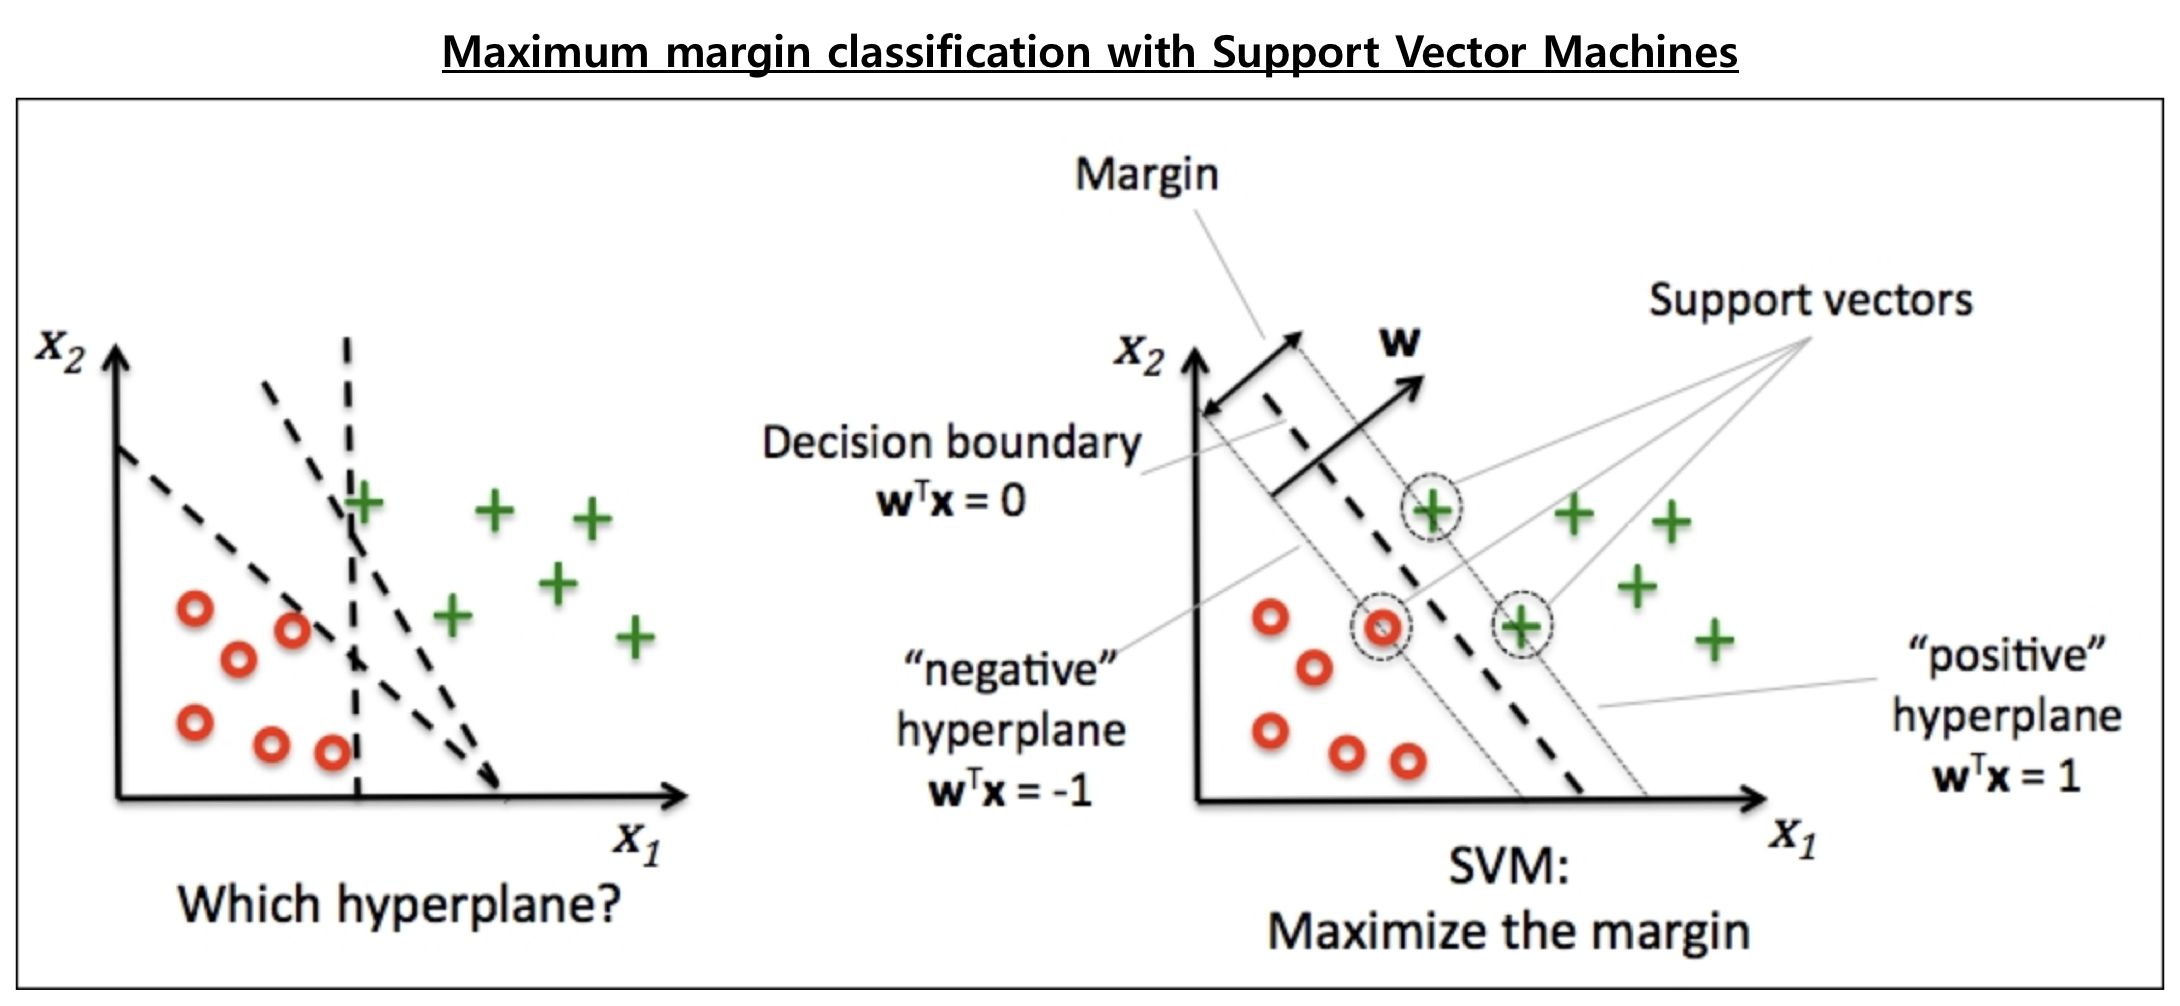

In [58]:
# image source: 'Python Machine Learning' by Sebastian Raschka
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'support_vector_machines.png'))

### 3-6. Linear SVM Classifier training

In [59]:
%%execsql

drop table if exists gpdemo.svm_mdl_newsgrps, gpdemo.svm_mdl_newsgrps_summary cascade;
select madlib.svm_classification(
    'gpdemo.twenty_news_groups_fvect_tfidf_train' -- source table
    , 'gpdemo.svm_mdl_newsgrps' -- model table
    , 'label'  -- dependent_varname
    , 'ind'    -- independent_varname
    , 'linear' -- kernel_func
)

- View the result for the linear classification model

In [60]:
%read_sql select * from gpdemo.svm_mdl_newsgrps;

Query started at 05:41:39 PM KST; Query executed in 0.00 m

coef  \
0  [-1.20970471278, 0.388767497331, 0.0436149846142, -0.000416699870298, -0.0794637072419, 0.0370824277013, 0.0460352776436, 0.0447336069615, 0.0887057211669, -0.212299788758, 0.00629421260825, 0.10952661422, 0.101981043364, 0.127669608634, 0.05067361205, 0.0818497499075, 0.214308288255, 0.0413936900166, 0.0452990792575, -0.42021705163, 0.082378746632, 0.0461648710062, 0.0467054046356, -0.133632197321, 0.0390472477687, 0.0427185557572, -0.231990633053, 0.0460352776436, 0.0345230996664, -0.00490919241917, -0.0267789294772, 1.18921246819, -0.0287570265286, 0.0365722039553, 0.0447336069615, 0.0412221208455, 0.0475918525069, -0.0172088851794, 0.153340349529, 0.0809876886549, 0.0272342707302, 0.04805002546, 0.0355872875169, 0.0728548384954, 0.0450680539158, 0.0872584736565, 0.0385798281918, 0.0725232957827, 0.138921501768, 0.52880014844, 0.404020458662, 0.169842495064, 0.170635245538, 0.108386622814, 0.037674818105, 0.175153463973, -0.064954778688, -0.109339862009, 0.250111745646, -0.06118...   

          loss  norm_of_gradient  num_iterations  num_rows_processed  \
0  1265.389328      16926.598543             100                6034   

   num_rows_skipped dep_var_mapping  
0                 0         [-1, 1]

### 3-7. Linear SVM prediction

In [61]:
%%execsql

drop table if exists gpdemo.twenty_news_groups_svm_predictions cascade;
select madlib.svm_predict(
    'gpdemo.svm_mdl_newsgrps' -- model_tabl
    , 'gpdemo.twenty_news_groups_fvect_tfidf_test' -- new_data_table (test set)
    , 'id' -- id_col_name
    , 'gpdemo.twenty_news_groups_svm_predictions' -- output_table
);

- View the result of classification with test set

In [62]:
%%read_sql

select a.*, b.label as actual
from gpdemo.twenty_news_groups_svm_predictions a
    jofin gpdemo.twenty_news_groups_fvect_tfidf_test b using (id) 
order by id
limit 30;

Query started at 05:41:50 PM KST; Query executed in 0.00 m

id  prediction  decision_function  actual
0    100          -1         -22.017533      -1
1   1001           1          39.790789       1
2   1002           1          10.391818       1
3   1005           1           9.227532       1
4   1008           1          23.530497       1
5   1010           1          30.352145       1
6   1014           1          44.564817       1
7   1018          -1          -0.254618       1
8    102          -1         -72.234339      -1
9   1021           1          51.984921       1
10  1022           1           6.172012       1
11  1023           1           5.844539       1
12  1024           1          23.291843       1
13  1028           1           3.919041       1
14   103          -1         -13.781712      -1
15  1032          -1         -12.917888       1
16  1033           1          26.003339       1
17  1036           1          22.241166       1
18  1039           1          38.922728       1
19  1044          -1         -32.897462       1
20  1045           1          28.227187       1
21  1050           1          22.369654       1
22  1055           1          15.241491       1
23  1056           1          14.892402       1
24  1058           1           9.243829       1
25   106          -1         -41.035355      -1
26  1060           1          27.121762       1
27  1061           1          16.664420       1
28  1065           1          19.138811       1
29  1067           1          44.282198       1

### 3-8. Show SVM prediction performance

Evaluation of binary classifiers with Confusion Matrix
- precision = TP/(TP+FP)
- recall, sensitivity, TPR = TP/(TP+FN)
- specificity = TN/(FP+TN)
- accuracy = (TP+TN)/N

*Image source: https://en.wikipedia.org/wiki/Evaluation_of_binary_classifiers*

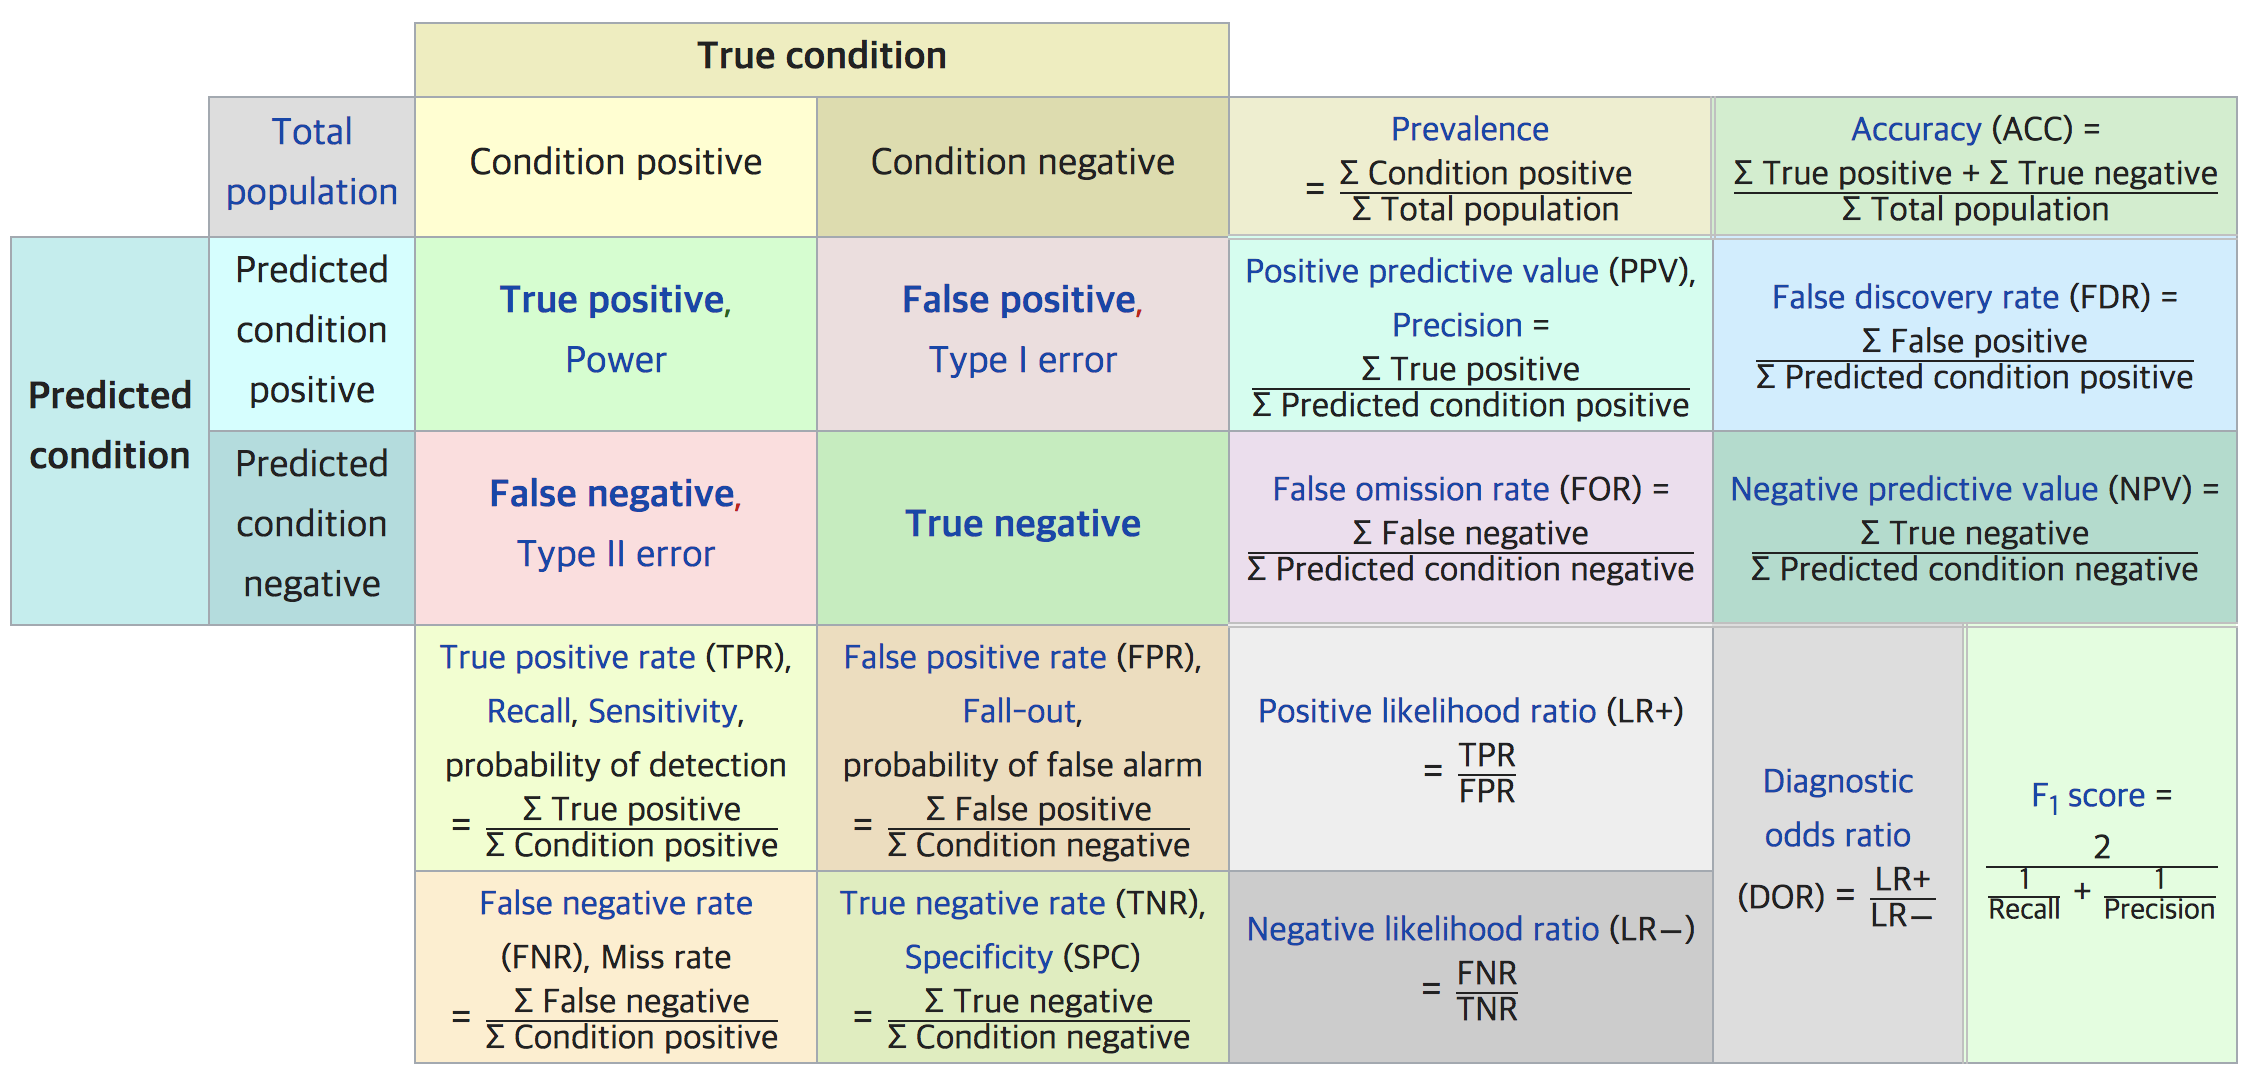

In [63]:
Image(filename=os.path.join(GPTEXT_PROJECT_PATH, 'evaluation_of_binary_classifiers.png'))

In [64]:
%%read_sql

select 'svm'::text as model, 
  round(sum(true_positive)*100.0/(sum(true_positive)+sum(false_positive)), 3) as precision
  , round(sum(true_positive)*100.0/(sum(true_positive)+sum(false_negative)), 3) as recall
  , round((sum(true_positive)+sum(true_negative))*100.0
    /(sum(true_positive)+sum(false_positive)+sum(false_negative)+sum(true_negative)), 3) as accuracy
from
(       
   select id,   
      case when actual_label=predicted_label and actual_label=1 then 1 else 0 end as true_positive,
      case when actual_label=-1 and predicted_label=1 then 1 else 0 end as false_positive,
      case when actual_label=1 and predicted_label=-1 then 1 else 0 end as false_negative,
      case when actual_label=-1 and predicted_label=-1 then 1 else 0 end as true_negative
   from
   (
       -- Show id, actual label & predicted label                 
       select t1.id, 
          t1.label as actual_label,
          case when t2.prediction > 0 then 1 else -1 end as predicted_label            
       from gpdemo.twenty_news_groups_fvect_tfidf_test t1, gpdemo.twenty_news_groups_svm_predictions t2
       where t1.id = t2.id
   ) q1
) q2;

Query started at 05:41:57 PM KST; Query executed in 0.00 m

model  precision  recall  accuracy
0   svm     94.261  95.846    94.907

You can try other classifiers, such as logistic regression, random forest classifier, naive bayes, etc.

- **Apache MADlib**: Big Data Machine Learning in SQL<br>
*For more information >>> http://madlib.apache.org/*

**The END**